# Sports Networks: Limits of PageRank-based ranking methods in sports data
Click on `Run/Run All Cells` before starting (ensure that the collapsed cells are executed). 

In [1]:
import math, random, itertools

import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx

import matplotlib.pyplot as plt

from scipy.stats import rankdata
from scipy.stats.mstats import kendalltau
    
from random import choices, sample

from tqdm.notebook import trange, tqdm

In [2]:
#############################################################################################
# configuration expansion

def expand_configuration(config):
    experiments = []

    for n_teams in config["n_teams"]:

        for fitness_d in _expand_fitness(n_teams, config["fitness"]):

            for model_d in _expand_model(config["model"]):

                for fraction_games_per_season in config["fraction_games_per_season"]: 
                                        
                    if config["fix_schedule_over_season"]:
                        if config["schedule"] == "graph":
                            schedule = generate_synthetic_sports_schedule_graph(n_teams, fraction_games_per_season)
                        elif config["schedule"] == "roundrobin":
                            schedule = generate_synthetic_sports_schedule_roundrobin(n_teams, fraction_games_per_season)
                        else:
                            raise ValueError(f"unknown schedule type: {config['schedule']}")
                    else:
                        schedule = None
                        
                    for unexpected_result in  _expand_handle_unexpected_results(config["remove_unexpected"]):       
                        
                        for season in range(config["n_seasons"]): # repetition
                            d = {
                                "n_teams": n_teams,
                                **fitness_d,
                                **model_d,
                                "fraction_games_per_season": fraction_games_per_season,
                                "season": season,
                                "schedule": schedule,
                                "remove_unexpected_mode": unexpected_result["mode"],
                                "remove_unexpected_fraction_eta": unexpected_result["fraction_eta"]
                            }
                            experiments.append(d)

    return experiments


def _expand_handle_unexpected_results(unexpected_config):
    
    exps = []
    for unexpected in unexpected_config:
        for mode, fraction_eta in itertools.product(unexpected["mode"], unexpected["fraction_eta"]):
            d = {
                "mode": mode,
                "fraction_eta": fraction_eta
            }
            exps.append(d)
    return exps


def _expand_fitness(n_teams, fitness_config):
    
    fitness_exp = []
    
    for fitness in fitness_config:
        if fitness["type"] == "linear":
            d = {
                "fitness_type": "linear",
                "fitness_values": linear_fitness(N=n_teams) 
            }
            
        elif fitness["type"] == "nonlinear":
            fitness_values = []
            for alpha, beta, gamma in itertools.product(fitness["alpha"], fitness["beta"], fitness["gamma"]):
                fitness_values += []
                
                d = {
                    "fitness_type": "nonlinear",
                    "fitness_nonlinear_alpha": alpha,
                    "fitness_nonlinear_beta": beta,
                    "fitness_nonlinear_gamma": gamma,                    
                    "fitness_values": nonlinear_fitness(N=n_teams, alpha=alpha, beta=beta, gamma=gamma)
                }
        else:
            raise ValueError(f"unknown fitness: {fitness}")
        
        fitness_values_inv = [-fitness_value for fitness_value in d["fitness_values"]]
        gt_ranking = rankdata(fitness_values_inv, method='min')        
        gt_ranking = [{"team": team_id, "rank": rank, "score": score} for team_id, (rank, score) in enumerate(zip(gt_ranking, d["fitness_values"]))]
        gt_ranking = sorted(gt_ranking, key=lambda k: k["rank"])
        d["gt_ranking"] = gt_ranking
        
        fitness_exp.append(d)
    
    return fitness_exp


def _expand_model(model_config):
    
    model_exp = []
    
    for model in model_config:
        if model["type"] == "logistic":
            for H, delta in itertools.product(model["H"], model["delta"]):
                d = {
                    "model": "logistic",
                    "model_logistic_H": H,
                    "model_logistic_delta": delta
                }
                model_exp.append(d)
        else:
            raise ValueError(f"unknown model: {model}")
        
    return model_exp



#############################################################################################
# fitness levels

def linear_fitness(N):
    return [(i-0.5)/N  for i in range(1, N+1)]

def nonlinear_fitness(N, alpha, beta, gamma):
    
    gamma0 = 0 if gamma == "fix" else gamma 
    
    fitness_values = [beta * (((i-0.5)/N) ** alpha) + gamma0  for i in range(1, N+1)]
    
    if gamma == "fix": # choose gamma such that avg fitness level == 0.5
        gamma0 = 0.5 - sum(fitness_values) / N
        fitness_values = [x + gamma0 for x in fitness_values]
        
    return fitness_values

#############################################################################################
# models

def logistic_model(f_i, f_j, H, delta):
    # f_i fitness value of team i (home team)
    # f_j fitness value of team j (away team)
    # H: home advantage
    # delta: randomness factor
    return sigmoid((f_i - f_j + H)/delta)

# TODO: in the paper math formula, I think they have an additional ^-1 which is wrong
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#############################################################################################
# simulate games
   
    

def generate_synthetic_sports_schedule_graph(n_teams, fraction_games_per_season):
    
    
    n_games = fraction_games_per_season * (n_teams - 1)
    
    n_games = int(n_games)
    
    total_n_games = fraction_games_per_season * n_teams * (n_teams-1) / 2
    
    sequence = [n_games] * n_teams
    
    n_teams_with_additional_game = 2 * int(total_n_games - n_games * n_teams / 2)
    
    teams_with_additional_game = sample(range(n_teams), n_teams_with_additional_game)
    for team in teams_with_additional_game:
        sequence[team] +=1
    
    assert(int(sum(sequence)/2) == int(total_n_games))
    
    # TODO with this approach you can only create a graph with fraction_of_games<=1    
    G = nx.random_degree_sequence_graph(sequence, seed=42, tries=1000)

    games = []
    for edge in G.edges():
        # home team is chosen at random for each game
        home_team_idx = random.randint(0, 1)
        away_team_idx = (home_team_idx + 1) % 2 
        
        home_team = edge[home_team_idx]
        away_team = edge[away_team_idx]
        
        games.append((home_team, away_team))
        
    return games


def _fixRoundRobinSchedule(teams):
    # from: https://code.activestate.com/recipes/65200/
    
    count = len(teams)
    assert(count % 2 == 0)
    
    n_matchdays = count - 1
    half = int(count/2)
    
    schedule = []
    
    for matchday in range(n_matchdays):
        games = []
        for i in range(half):
            team1 = teams[i]
            team2 = teams[count-i-1]
            games.append((team1, team2))
        
        teams.insert(1, teams.pop())
        schedule.append(games)
    
    return schedule

def generate_synthetic_sports_schedule_roundrobin(n_teams, fraction_games_per_season):

    teams = list(range(0,n_teams))

    schedule = _fixRoundRobinSchedule(teams)

    # random permutation of teams
    random.shuffle(teams)

    home_counter = {team: 0 for team in teams}

    # apply permutation of teams in schedule
    schedule_new = []
    for matchday in schedule:
        matchday_new = []
        for game in matchday:
            game =  (teams[game[0]], teams[game[1]])
            matchday_new.append(game)
        schedule_new.append(matchday_new)

    # apply permutation of matchdays
    random.shuffle(schedule_new)

    n_games_total = int(fraction_games_per_season * n_teams * (n_teams-1) / 2)

    n_games_total = int(n_games_total)
    games = []
    for matchday in schedule_new:

        matchday_games = []

        for game in matchday:
            t0_home_count = home_counter[game[0]]
            t1_home_count = home_counter[game[1]]

            if t0_home_count > t1_home_count:
                # t1 is home team -> need to change
                game = (game[1], game[0])
            elif t0_home_count == t1_home_count and random.randint(0, 1) == 0:
                # random home team
                game = (game[1],game[0])

            home_counter[game[0]] += 1

            matchday_games.append(game)

        if len(games) + len(matchday_games) <= n_games_total:
            games += matchday_games
        else: # cannot add all games of the matchday
            # need to determine which games of a matchday to include
            random.shuffle(matchday_games)
            n_games_remaining = n_games_total - len(games)
            games += matchday_games[0:n_games_remaining]
            break

    assert(len(games)==n_games_total)

    """ Shows that number of home games is evenly distributed
    h_counter = {team: 0 for team in teams}

    for game in games:
        h_counter[game[0]] +=1

    display(h_counter)
    """

    return games


def generate_synthetic_sports_results(exp, schedule):
    # fraction of games can also be > 1 (league where teams play more than once against each other)    
    
    games = []
    for scheduled_game in schedule:
       
        home_team = scheduled_game[0]
        away_team = scheduled_game[1]
        
        if exp["model"] == "logistic": 
            prob_home_team_win = logistic_model(f_i=exp["fitness_values"][home_team], f_j=exp["fitness_values"][away_team], H=exp["model_logistic_H"], delta=exp["model_logistic_delta"])
            home_team_win = bool(np.random.binomial(n=1, p=prob_home_team_win))
            
            result = "home" if home_team_win else "away"
        else:
            raise ValueError(f"Not Implemented Yet: model={model}")
        
        game = {
            "home": home_team,
            "away": away_team,
            "result": result
        }
        
        games.append(game)
        
    return games


def remove_unexpected_results(games, fitness_values, mode, fraction_eta):
    
    new_games = []
    unexpected_games = []
    
    for game in games:
        
        home_fitness = fitness_values[game["home"]]
        away_fitness = fitness_values[game["away"]]
        
        winner = game["result"]
        
        unexpected_result = (winner == "home" and home_fitness < away_fitness) or (winner == "away" and away_fitness < home_fitness)
        
        if unexpected_result:
            unexpected_games.append(game)
        else:
            new_games.append(game)
    
    
    n_games_to_update = int(fraction_eta * len(unexpected_games))
    
    random.shuffle(unexpected_games)
    
    for i, game in enumerate(unexpected_games):
        if i < n_games_to_update:
            if mode == "removal":
                #print(f"    update (remove): {game}")
                pass
            elif mode == "reversion":
                #print(f"    update (reversion): {game}")
                game["result"] = "home" if game["result"] == "away" else "away"
                new_games.append(game)
            else:
                raise ValueError(f"unknown remove unexpected mode: {mode}")
        else:
            new_games.append(game)
    
    info = f"updated={n_games_to_update} unexpected={len(unexpected_games)}({round(100*len(unexpected_games)/len(games))}%) total={len(games)}"
    return new_games, info

#############################################################################################
# game results to graph

def games_to_graph(n_teams, games, graph="winner"):
    
    G = nx.DiGraph(directed=True)
    G.add_nodes_from(range(0, n_teams))
    
    edges = []
    for game in games:
           
        if game["result"] == "home":
            winner = game["home"]
            loser = game["away"]
        elif game["result"] == "away":
            winner = game["away"]
            loser = game["home"]
        else:
            raise ValueError("Not Implemented Yet")
        
        if graph == "winner":
            # when team i wins against team j => a directed link from j to i "along which sports prestige flows"
            e = (loser, winner, 1)
        elif graph == "loser":
             # when team i wins against team j => a directed link from i to j
            e = (winner, loser, 1)
        else:
            raise ValueError(f"unknown graph type: {graph}")
        edges.append(e)
    
    # TODO at the moment each team can only against each other team once => don't need to combine edge weights
    
    G.add_weighted_edges_from(edges) # (start node, dest node, weight)
    
    return G

#############################################################################################
# ranking algos

def winratio(winner_graph):
    scores = {}
            
    for team in winner_graph.nodes():
        n_wins = winner_graph.in_degree(team)
        n_losses = winner_graph.out_degree(team)
        win_ratio = n_wins / (n_wins + n_losses)
        scores[team] =  win_ratio
    return scores
    

def bipagerank(winner_graph, loser_graph):
    scores_P = nx.pagerank(winner_graph)
    scores_Q = nx.pagerank(loser_graph)
            
    scores = {}
    for team, score_P in scores_P.items():
        score_Q = scores_Q[team]
        scores[team] = score_P - score_Q
    
    return scores


def scores_to_ranking(scores):
    
    # sort team by team index
    team_scores = [-score for team, score in sorted(scores.items(), key=lambda item: item[0])]
    
    # apply the ranking
    ranking = rankdata(team_scores, method='min')
    
    # convert ranking to dictionary (same form as scores)
    team_ranking = {team: {"rank": rank, "score": scores[team]} for team, rank in enumerate(ranking)}
    
    return team_ranking

#############################################################################################

# metrics
def topk_avg_rank(team_ranking, ranking_gt, k=5):
    
    top_k_teams = ranking_gt[:k]

    rank_sum = 0
    for x in top_k_teams:
        team_id = x["team"]
        rank_sum += team_ranking[team_id]["rank"]
    
    avg_rank_sum = rank_sum / k
    return avg_rank_sum

def kendall(team_ranking, ranking_gt):
    
    gt_ranking_lst = [x["rank"] for x in sorted(ranking_gt, key=lambda x: x["team"])]
    algo_ranking_lst = [team_ranking[team_id]["rank"] for team_id in sorted(team_ranking.keys())]
    
    
    tau_a, _ = kendalltau(algo_ranking_lst, gt_ranking_lst, use_ties=False, use_missing=False, method='auto')
    
    return tau_a


gt_ranking = [{'team': 4, 'rank': 1}, {'team': 3, 'rank': 2}, {'team': 2, 'rank': 3}, {'team': 1, 'rank': 4}, {'team': 0, 'rank': 5}]
team_ranking = {0: {'rank': 1}, 1: {'rank': 1}, 2: {'rank': 1}, 3: {'rank': 1}, 4: {'rank': 1}}
score = kendall(team_ranking, gt_ranking)
assert(score == 0)

team_ranking = {0: {'rank': 5}, 1: {'rank': 4}, 2: {'rank': 3}, 3: {'rank': 2}, 4: {'rank': 1}}
score = kendall(team_ranking, gt_ranking)
assert(score == 1)

team_ranking = {0: {'rank': 1}, 1: {'rank': 2}, 2: {'rank': 3}, 3: {'rank': 4}, 4: {'rank': 5}}
score = kendall(team_ranking, gt_ranking)
assert(score == -1)


def auc(team_ranking, ranking_gt, n, topk=5):
    
    goal_top_set = ranking_gt[:topk]
    ordinary_set = ranking_gt[topk:]
    
    # sample with replacement
    goal_top_set_samples = choices(goal_top_set,k=n)
    ordinary_set_samples = choices(ordinary_set,k=n)
    
    goal_higher_count = 0
    tied_count = 0
    for goal_team, ordinary_team in zip(goal_top_set_samples, ordinary_set_samples):
        
        goal_team_id = goal_team["team"]
        ordinary_team_id = ordinary_team["team"]
        
        goal_team_rank = team_ranking[goal_team_id]["rank"]
        ordinary_team_rank = team_ranking[ordinary_team_id]["rank"]
 
        if goal_team_rank < ordinary_team_rank:
            goal_higher_count += 1
        elif goal_team_rank == ordinary_team_rank:
            tied_count += 1

    
    auc = (goal_higher_count + tied_count/2) / n
    
    return auc

#############################################################################################


In [3]:
import time

def build_df(config):   
    experiments = expand_configuration(config)
    
    print(f"Config results in {len(experiments)} experiments")

    # simulate seasons
    for exp in tqdm(experiments):
        #print("========================================")
        #start_time = time.time()
        
        if "schedule" not in exp or exp["schedule"] is None:
            if config["schedule"] == "graph":
                schedule = generate_synthetic_sports_schedule_graph(exp["n_teams"], exp["fraction_games_per_season"])
            elif config["schedule"] == "roundrobin":
                schedule = generate_synthetic_sports_schedule_roundrobin(exp["n_teams"], exp["fraction_games_per_season"])
            else:
                raise ValueError(f"unknown schedule type: {config['schedule']}")
        else:
            schedule = exp["schedule"]
        
        exp["results"] = generate_synthetic_sports_results(exp, schedule)
        
        exp["results"], exp["remove_unexpected_info"] = remove_unexpected_results(exp["results"], fitness_values=exp["fitness_values"], mode=exp["remove_unexpected_mode"], fraction_eta=exp["remove_unexpected_fraction_eta"])
        
        #print(f"generate synthetic: {time.time()-start_time} ")
        winner_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")
        
        #print(f"games to graph: {time.time()-start_time} ")

        # apply the ranking algorithms to the simulated seasons
        for ranking_algo in config["ranking_algos"]:
            if ranking_algo == "pagerank":
                scores = nx.pagerank(winner_graph)
                #print(f"pagerank: {time.time()-start_time} ")
            elif ranking_algo == "bipagerank":
                loser_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="loser")
                scores = bipagerank(winner_graph, loser_graph)
                #print(f"bipagerank: {time.time()-start_time} ")
            elif ranking_algo == "winratio":
                scores = winratio(winner_graph)
                #print(f"winratio: {time.time()-start_time} ")
            else:
                raise ValueError(f"unknown ranking algo: {ranking_algo}")            
            
            team_ranking = scores_to_ranking(scores)
            
            # {<team_id>: {"rank": <rank>, "score": <score>}, ...}
            
            exp[f"{ranking_algo}_team_ranking"] = team_ranking
            
            # evaluate each ranking with the defined metrics
            for metric in config["metrics"]:
                if metric == "top5_avg_rank":
                    metric_score = topk_avg_rank(team_ranking, ranking_gt=exp["gt_ranking"], k=5)
                    #print(f"top5 avg rank: {time.time()-start_time}")

                elif metric == "kendall":
                    metric_score = kendall(team_ranking, ranking_gt=exp["gt_ranking"])
                    #print(f"kendall: {time.time()-start_time} ")

                elif metric == "auc":
                    metric_score = auc(team_ranking, ranking_gt=exp["gt_ranking"], n=100 , topk=5) # n is the number of sampled pairs
                    #print(f"auc: {time.time()-start_time} ")

                else:
                    raise ValueError(f"unknown metric: {metric}")

                exp[f"{ranking_algo}_{metric}"] = metric_score
   
    df = pd.DataFrame(experiments)
    
    # only keep the important columns 
    return df

def drop_additional_cols(df1):
    df1 = df1[df1.columns.drop(list(df1.filter(regex='_ranking')))]
    df1 = df1[df1.columns.drop(list(df1.filter(regex='_scores')))]
    df1 = df1.drop(columns=["fitness_values", "results", "schedule"])
    return df1

## Example for Pipeline Config

In [4]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}, 
                {"type": "nonlinear", "alpha": [1], "beta":[0.4], "gamma": ["fix"] }],
    "model": [{"type": "logistic", "H": [0.1875], "delta": [0.25] }],
    "fraction_games_per_season":  [1], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 100, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df = build_df(config)
display(drop_additional_cols(df))

Config results in 200 experiments


  0%|          | 0/200 [00:00<?, ?it/s]

,n_teams,fitness_type,model,model_logistic_H,model_logistic_delta,fraction_games_per_season,season,remove_unexpected_mode,remove_unexpected_fraction_eta,remove_unexpected_info,...,pagerank_auc,bipagerank_top5_avg_rank,bipagerank_kendall,bipagerank_auc,winratio_top5_avg_rank,winratio_kendall,winratio_auc,fitness_nonlinear_alpha,fitness_nonlinear_beta,fitness_nonlinear_gamma
0,30,linear,logistic,0.1875,0.25,1,0,removal,0.0,updated=0 unexpected=105(24%) total=435,...,0.92,3.4,0.834483,0.99,3.4,0.813793,0.960,NaN,NaN,NaN
1,30,linear,logistic,0.1875,0.25,1,1,removal,0.0,updated=0 unexpected=100(23%) total=435,...,1.00,4.8,0.848276,0.93,4.0,0.866667,0.940,NaN,NaN,NaN
2,30,linear,logistic,0.1875,0.25,1,2,removal,0.0,updated=0 unexpected=109(25%) total=435,...,0.94,5.8,0.719540,0.90,4.2,0.779310,0.910,NaN,NaN,NaN
3,30,linear,logistic,0.1875,0.25,1,3,removal,0.0,updated=0 unexpected=105(24%) total=435,...,1.00,3.4,0.788506,0.99,3.2,0.822989,0.990,NaN,NaN,NaN
4,30,linear,logistic,0.1875,0.25,1,4,removal,0.0,updated=0 unexpected=111(26%) total=435,...,0.99,3.8,0.811494,0.95,3.0,0.811494,0.990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,30,nonlinear,logistic,0.1875,0.25,1,95,removal,0.0,updated=0 unexpected=166(38%) total=435,...,0.90,6.4,0.498851,0.80,5.6,0.505747,0.895,1.0,0.4,fix
196,30,nonlinear,logistic,0.1875,0.25,1,96,removal,0.0,updated=0 unexpected=186(43%) total=435,...,0.74,10.6,0.489655,0.70,10.0,0.457471,0.680,1.0,0.4,fix
197,30,nonlinear,logistic,0.1875,0.25,1,97,removal,0.0,updated=0 unexpected=174(40%) total=435,...,0.80,7.4,0.448276,0.85,5.6,0.480460,0.850,1.0,0.4,fix
198,30,nonlinear,logistic,0.1875,0.25,1,98,removal,0.0,updated=0 unexpected=183(42%) total=435,...,0.72,7.6,0.503448,0.84,6.6,0.494253,0.825,1.0,0.4,fix


In [5]:
%time
# (~ 16 min) 

# configure here the experiments (the pipeline will create a cross product for every element in a list)
# config = {
#     "n_teams": [30],
#     "fitness": [{"type": "linear"}],
#     "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 5), "delta": np.linspace(0.01,0.35, 5) }],
#     "fraction_games_per_season":  [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
#     "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
#     "n_seasons": 100, # number of repetitions
#     "ranking_algos": ["pagerank", "bipagerank", "winratio"],
#     "metrics": ["kendall", "auc", "top5_avg_rank"],
#     "fix_schedule_over_season": False,
#     "schedule": "graph" # "roundrobin"
# }

# df = build_df(config)

# display(drop_additional_cols(df))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


# Real data


In [6]:
import os
import re

directory = "data"
pattern = "^(\\d{4})-(\\d{4}) ([a-zA-Z ]*) \\(([A-Z])\\).csv$"

real_data_games = pd.DataFrame()

for filename in os.listdir(directory):
    match = re.search(pattern, filename)
    if not match:
        continue

    start_year = int(match.group(1))
    end_year = int(match.group(2))
    league_name = match.group(3)

    content = pd.read_csv(os.path.join(directory, filename), delimiter=";").dropna(how='all')
    content["start_year"] = start_year
    content["end_year"] = end_year
    content["league_name"] = league_name
    real_data_games = real_data_games.append(content)

display(real_data_games)

,Wk,Day,Date,Time,Home,Score,Away,Attendance,Venue,Referee,Match Report,Notes,start_year,end_year,league_name,xG,xG.1
0,1.0,Sat,14.08.10,NaN,Blackburn,1–0,Everton,NaN,NaN,Phil Dowd,Match Report,NaN,2010,2011,Premier League,NaN,NaN
1,1.0,Sat,14.08.10,NaN,Chelsea,6–0,West Brom,NaN,NaN,Mark Clattenburg,Match Report,NaN,2010,2011,Premier League,NaN,NaN
2,1.0,Sat,14.08.10,NaN,Sunderland,2–2,Birmingham City,NaN,NaN,Anthony Taylor,Match Report,NaN,2010,2011,Premier League,NaN,NaN
3,1.0,Sat,14.08.10,NaN,Bolton,0–0,Fulham,NaN,NaN,Stuart Attwell,Match Report,NaN,2010,2011,Premier League,NaN,NaN
4,1.0,Sat,14.08.10,NaN,Wigan Athletic,0–4,Blackpool,NaN,NaN,Mark Halsey,Match Report,NaN,2010,2011,Premier League,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,34.0,Sat,10.05.14,NaN,Hertha BSC,0–4,Dortmund,NaN,NaN,Tobias Stieler,Match Report,NaN,2013,2014,Bundesliga,NaN,NaN
336,34.0,Sat,10.05.14,NaN,Mainz 05,3–2,Hamburger SV,NaN,NaN,Thorsten Kinhöfer,Match Report,NaN,2013,2014,Bundesliga,NaN,NaN
337,34.0,Sat,10.05.14,NaN,Hannover 96,3–2,Freiburg,NaN,NaN,Peter Gagelmann,Match Report,NaN,2013,2014,Bundesliga,NaN,NaN
338,34.0,Sat,10.05.14,NaN,Augsburg,2–1,Eint Frankfurt,NaN,NaN,Daniel Siebert,Match Report,NaN,2013,2014,Bundesliga,NaN,NaN


In [7]:
real_data_teams = pd.DataFrame()

for _, (start_year, end_year, league) in real_data_games[["start_year", "end_year", "league_name"]]\
                                        .drop_duplicates().iterrows():
    season = real_data_games[(real_data_games["start_year"] == start_year) &\
                             (real_data_games["end_year"] == end_year) &\
                             (real_data_games["league_name"] == league)]
    
    teams_home = season["Home"].unique()
    teams_away = season["Away"].unique()
    diff = np.setdiff1d(teams_home, teams_away)
    assert diff.shape[0] == 0, "Teams Home and Away must be the same!"
    
    n_teams = teams_home.shape[0]
    

    v = season["Score"].str.split("–", expand=True)
#     games = season[v[0] != v[1]] # Filter draws
    games_home_won = season[v[0] > v[1]]
    games_away_won = season[v[0] < v[1]]
    
    
    teams_playcount = {
        team: len(season[(((season["Home"] == team) | (season["Away"] == team)) & (v[0] != v[1]))].index) for team in teams_home
    }
    teams_playcount_home = {
        team: len(season[(((season["Home"] == team)) & (v[0] != v[1]))].index) for team in teams_home
    }
    teams_playcount_away = {
        team: len(season[(((season["Away"] == team)) & (v[0] != v[1]))].index) for team in teams_home
    }
    
    winning_teams_home = season[v[0] > v[1]]["Home"]
    winning_teams_away = season[v[0] < v[1]]["Away"]
    winning_teams = winning_teams_home.append(winning_teams_away).sort_index()
    
    teams_wincount = {
        team: (len(winning_teams[winning_teams == team].index), len(winning_teams_home[winning_teams_home == team].index), len(winning_teams_away[winning_teams_away == team].index)) for team in teams_home
    }
    
    teams_winratio = {
        team: (wins_total / teams_playcount[team], wins_home / teams_playcount_home[team], wins_away / teams_playcount_away[team]) for team, (wins_total, wins_home, wins_away) in teams_wincount.items()
    }
    teams_sorted = list(teams_winratio.items())
    teams_sorted.sort(key=lambda x: x[1], reverse=False)
    
    df = pd.DataFrame({
        'rank': range(1, n_teams + 1),
        'team': [x[0] for x in teams_sorted],
        'win_ratio': [x[1][0] for x in teams_sorted],
        'win_ratio_home': [x[1][1] for x in teams_sorted],
        'win_ratio_away': [x[1][2] for x in teams_sorted],
        'league': league,
        'start_year': start_year,
        'end_year': end_year
    })
    real_data_teams = real_data_teams.append(df)

In [8]:
display(real_data_teams)

,rank,team,win_ratio,win_ratio_home,win_ratio_away,league,start_year,end_year
0,1,West Ham,0.269231,0.357143,0.166667,Premier League,2010,2011
1,2,Blackpool,0.344828,0.357143,0.333333,Premier League,2010,2011
2,3,Birmingham City,0.347826,0.545455,0.166667,Premier League,2010,2011
3,4,Wolves,0.354839,0.533333,0.187500,Premier League,2010,2011
4,5,Wigan Athletic,0.391304,0.454545,0.333333,Premier League,2010,2011
...,...,...,...,...,...,...,...,...
13,14,Leverkusen,0.633333,0.714286,0.562500,Bundesliga,2013,2014
14,15,Wolfsburg,0.642857,0.785714,0.500000,Bundesliga,2013,2014
15,16,Schalke 04,0.703704,0.800000,0.583333,Bundesliga,2013,2014
16,17,Dortmund,0.758621,0.733333,0.785714,Bundesliga,2013,2014


# Fitting (Figure 1)

In [9]:
from scipy.optimize import minimize

def winratio_model(delta_w, H, delta):
    # delta_w difference in winratio between team i (home team) and team j (away team)
    # H: home advantage
    # delta: randomness factor
    return sigmoid((delta_w + H)/delta)

def gen_data_likelihood(X, Y):
    def data_likelihood(theta):
        # X: empirical winratio difference
        # Y: Game results, binary
        H, delta = theta[0], theta[1]
        P = winratio_model(X, H, delta)
        return -np.sum(np.log((Y * P) + ((1 - Y) * (1 - P))))
    
    return data_likelihood


Removed 0 rows out of 3366!
H: 0.08430890565771242, delta 0.2050129726151425, loss 1392.47859042842
Removed 2 rows out of 3800!
H: 0.08301170847917089, delta 0.2039698160734401, loss 1524.0675461403832


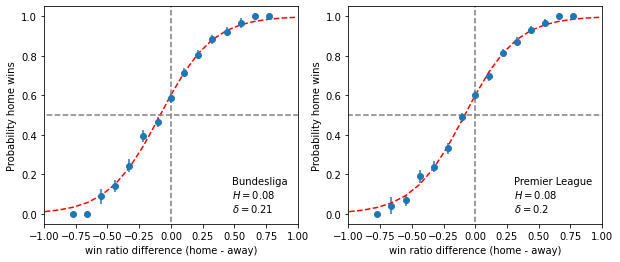

win_ratio_bin  home_won           win_ratio_bin_mid
                          mean       sem                  
0    (-1.05, -0.939]       NaN       NaN           -0.9945
1   (-0.939, -0.828]       NaN       NaN           -0.8835
2   (-0.828, -0.717]  0.000000  0.000000           -0.7725
3   (-0.717, -0.606]  0.041667  0.041667           -0.6615
4   (-0.606, -0.494]  0.069767  0.027632           -0.5500
5   (-0.494, -0.383]  0.189873  0.031301           -0.4385
6   (-0.383, -0.272]  0.238298  0.027851           -0.3275
7   (-0.272, -0.161]  0.332180  0.027754           -0.2165
8    (-0.161, -0.05]  0.487864  0.024656           -0.1055
9      (-0.05, 0.05]  0.599502  0.024469            0.0000
10     (0.05, 0.161]  0.696822  0.022755            0.1055
11    (0.161, 0.272]  0.814103  0.022060            0.2165
12    (0.272, 0.383]  0.872093  0.020833            0.3275
13    (0.383, 0.494]  0.931818  0.019054            0.4385
14    (0.494, 0.606]  0.967391  0.018619            0.5500
15    (0.606, 0.717]  1.000000  0.000000            0.6615
16    (0.717, 0.828]  1.000000  0.000000            0.7725
17    (0.828, 0.939]       NaN       NaN            0.8835
18     (0.939, 1.05]       NaN       NaN            0.9945

In [10]:
from scipy.optimize import minimize
from matplotlib.offsetbox import AnchoredText


NUM_BINS = 21

leagues = ["Bundesliga", "Premier League"]

# Build bins
bins_on_either_side = int(NUM_BINS / 2)
half_bin_size = 0.5 / float(bins_on_either_side)
positive_bins = np.linspace(0, 1.0, bins_on_either_side)
positive_bins += half_bin_size
negative_bins = np.linspace(-1.0, 0, bins_on_either_side)
negative_bins -= half_bin_size
bins = np.concatenate([negative_bins, positive_bins])

fig, axes = plt.subplots(1, 2, figsize=[10, 4])

for i, league in enumerate(leagues):
    
    ##################
    # Empirical Part #
    ##################
    real_data_games_league = real_data_games[real_data_games["league_name"] == league]
    
    relevant_cols = ["team", "win_ratio", "start_year"]
    all_games_with_winratios = real_data_games_league.merge(real_data_teams[relevant_cols], left_on=['Home', 'start_year'], right_on=['team', 'start_year']) \
        .merge(real_data_teams[relevant_cols], left_on=['Away', 'start_year'], right_on=['team', 'start_year'])
    all_games_with_winratios["delta_w"] = all_games_with_winratios['win_ratio_x'] - all_games_with_winratios['win_ratio_y']

    all_games_with_winratios['win_ratio_bin'] = pd.cut(all_games_with_winratios['delta_w'], bins)
    
    count_before_remove_4 = all_games_with_winratios["win_ratio_bin"].count()

    col = ["win_ratio_bin"]
    less_than_games = 4
    all_games_with_winratios = all_games_with_winratios.groupby(col).filter(lambda x : (x[col].count()>=less_than_games).any())

    print(f'Removed {count_before_remove_4 - all_games_with_winratios["win_ratio_bin"].count()} rows out of {count_before_remove_4}!')

    # Now calculate if home won
    v = all_games_with_winratios["Score"].str.split("–", expand=True)
    all_games_with_winratios["home_won"] = (v[0] > v[1]).astype(int)
    all_games_with_winratios = all_games_with_winratios[v[0] != v[1]]  # Filter draws

    home_won_per_bin = all_games_with_winratios.groupby('win_ratio_bin').agg({'home_won':['mean','sem']}).reset_index()
    home_won_per_bin['win_ratio_bin_mid'] = home_won_per_bin['win_ratio_bin'].apply(lambda x: x.mid)
    
    ############
    # MLE Part #
    ############
    mle_X = all_games_with_winratios["delta_w"]
    mle_Y = all_games_with_winratios["home_won"]

    model = minimize(gen_data_likelihood(mle_X, mle_Y), [0.1, 3], method='Nelder-Mead')
    mle_H = round(model["x"][0] * 100) / 100
    mle_delta = round(model["x"][1] * 100) / 100
    print(f"H: {model['x'][0]}, delta {model['x'][1]}, loss {model['fun']}")

    ############
    # Plotting #
    ############
    X = home_won_per_bin['win_ratio_bin_mid']
    axes[i].errorbar(X, home_won_per_bin['home_won']['mean'], yerr=home_won_per_bin['home_won']['sem'], \
                     marker='o', linestyle='')
    
    axes[i].plot(X, winratio_model(X.to_numpy(), model['x'][0], model['x'][1]), color='red', linestyle='dashed')
    
    axes[i].set_ylabel("Probability home wins")
    axes[i].set_xlabel("win ratio difference (home - away)")
    axes[i].set_xlim(-1.0, 1.0)
    axes[i].set_ylim(-0.05, 1.05)
    
    axes[i].axhline(0.5, -1.1, 1.1, linestyle='dashed', color='gray')
    axes[i].axvline(0.0, -0.1, 1.1, linestyle='dashed', color='gray')
    
    textstr = '\n'.join((
    f'{league}',
    f'$H={mle_H}$',
    f'$\\delta={mle_delta}$'))

    # place a text box in upper left in axes coords
    text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=1.0, edgecolor='none')
    axes[i].add_artist(text_box)

plt.show()
    
display(home_won_per_bin)

# Figure 2

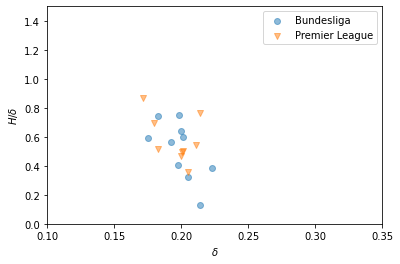

,league,start_year,H,delta
0,Bundesliga,2010,0.085889,0.223237
1,Bundesliga,2011,0.119988,0.201367
2,Bundesliga,2012,0.066782,0.204987
3,Bundesliga,2013,0.108875,0.192380
4,Bundesliga,2014,0.149042,0.198284
5,Bundesliga,2015,0.079626,0.197763
6,Bundesliga,2016,0.135970,0.182509
7,Bundesliga,2017,0.127901,0.200247
8,Bundesliga,2018,0.104189,0.175083
9,Bundesliga,2019,0.028282,0.213942


In [11]:

relevant_cols = ["team", "win_ratio", "start_year", "league"]

all_games_with_winratios = real_data_games.merge(real_data_teams[relevant_cols], left_on=['Home', 'start_year', 'league_name'], right_on=['team', 'start_year', 'league']) \
    .merge(real_data_teams[relevant_cols], left_on=['Away', 'start_year', 'league_name'], right_on=['team', 'start_year', 'league'])
all_games_with_winratios["delta_w"] = all_games_with_winratios['win_ratio_x'] - all_games_with_winratios['win_ratio_y']

# Now calculate if home won
v = all_games_with_winratios["Score"].str.split("–", expand=True)
all_games_with_winratios["home_won"] = (v[0] > v[1]).astype(int)
all_games_with_winratios = all_games_with_winratios[v[0] != v[1]]  # Filter draws

def compute_theta(x):
    mle_X = x["delta_w"]
    mle_Y = x["home_won"]

    model = minimize(gen_data_likelihood(mle_X, mle_Y), [0.1, 3], method='Nelder-Mead')
    return model["x"][0], model["x"][1]

grouped = all_games_with_winratios[["delta_w", "home_won", "league_name", "start_year"]].groupby(['league_name', 'start_year'])
models = { i: (name + compute_theta(group)) for i, (name, group) in enumerate(grouped)}
models = pd.DataFrame.from_dict(models, orient='index', columns=['league', 'start_year', 'H', 'delta'])

config_figure_2 = {
    "Bundesliga": {'marker': 'o', 'color': 'red'},
    "Premier League": {'marker': 'v', 'color': 'yellow'},
}

plt.figure()
for i, (league, rows) in enumerate(models.groupby('league')):
    current_league_models = models
    plt.scatter(rows['delta'], rows['H'] / rows['delta'], \
               marker=config_figure_2[league]['marker'], color=plt.cm.tab10(i), \
               alpha=0.5, label=league)

plt.xlabel("$\\delta$")
plt.xlim(0.1, 0.35)
plt.ylabel("$H/\\delta$")
plt.ylim(0.0, 1.5)
plt.legend()
plt.show()

display(models)


# Plotting

In [12]:
from scipy.optimize import least_squares

def nonlinear_fitness_model(theta, i, N):
    """
    N is fixed
    gamma is set after tweaking alpha and beta to normalize.
    """
    alpha, beta, gamma = theta[0], theta[1], theta[2]
    # print(alpha, beta)
    return beta * np.power((i - 0.5) / N, alpha) + gamma
    # return theta[0] / (1 + np.exp(- theta[1] * (t - theta[2])))
    
    
def determine_gamma(alpha, beta, N):
    """
    In case choose alfa and beta, we should be normalize the winratios so that the average is always 0.5 (someones win
    is always someone elses loss).
    This should be implicit in the natural data that we get.
    :return: gamma
    """
    average = np.sum([nonlinear_fitness_model([alpha, beta], i, N) for i in range(1, N+1)]) / N
    return 0.5 - average


def fit_nonlinear_model(df, visualize=False):

    # Prepare datapoints
    N = df['rank'].count()
    X = df['rank'].values
    Y = df['win_ratio'].values
    def fun(theta):
        return nonlinear_fitness_model(theta, X, N) - Y

    theta0 = [0.5,2, 0]
    result = least_squares(fun, theta0)
    result_theta = result.x

    if visualize:
        plt.scatter(X, Y, color="red")
        plt.plot(X, [nonlinear_fitness_model(result_theta, t, N) for t in X])
        for label, (x, y) in zip(df['team'].values, zip(X, Y)):
            plt.annotate(label, (x, y))
        print(f"Average winratio input: {np.sum(Y) / N}")
        print(f"Average winratio: {np.sum([nonlinear_fitness_model(result_theta, t, N) for t in X]) / N}")

    if visualize:
        print(np.sum([nonlinear_fitness_model(result_theta, t, N) for t in X]) / N)
        plt.plot(X, [nonlinear_fitness_model(result_theta, t, N) for t in X], color='green')

        print(f"alpha={result_theta[0]}, beta={result_theta[1]}, gamma={result_theta[2]}")

    return result_theta[0], result_theta[1], result_theta[2]

Premier League (2010-2011)
Average winratio input: 0.4987532485382028
Average winratio: 0.49875324854706066
0.49875324854706066
alpha=2.0931981872778724, beta=0.49343621876913063, gamma=0.3393379403912956


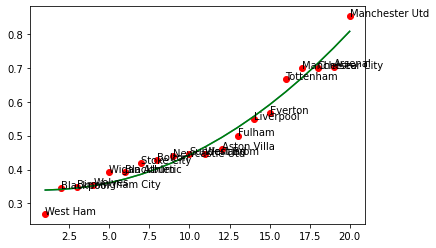

In [13]:
print("Premier League (2010-2011)")
data_premier_league_2010 = real_data_teams[(real_data_teams["league"] == "Premier League") & (real_data_teams["start_year"] == 2010)]
_, _, _ = fit_nonlinear_model(data_premier_league_2010, visualize=True)

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


In [15]:

# General plotting config

COLOR_GRAY = '#666666'

plot_config = {
    'colors': {
        0.1: 'red',
        0.3: 'green',
        0.8: 'blue',

        # Smaller data
        0.5: 'red',
        1.0: 'green',
        
        # algos
        "winratio": 'green',
        "pagerank": 'red',
        "bipagerank": 'blue'
    },
    'linestyles': {
        "pagerank": "dashed",
        "bipagerank": "dotted",
        "winratio": "solid"
    },
    'algo_names': {
        "pagerank": "PageRank",
        "bipagerank": "BiPageRank",
        "winratio": "WinRatio"
    },
    'ylabels': {
        "top5_avg_rank": "average ranking of top 5",
        "kendall": "Kendall $\\tau$",
        "auc": "AUC of top 5"
    },
    "update_removal_mode_names":{
        "removal": "upset removal",
        "reversion": "upset reversion"
    }
}

In [16]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": [0], "delta": np.linspace(0.01, 0.4, 4) }],
    "fraction_games_per_season": np.concatenate([np.linspace(0.04, 1.0, 4), [0.1, 0.3, 0.8]]), # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df = build_df(config)
display(drop_additional_cols(df))

Config results in 1400 experiments


  0%|          | 0/1400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

plot_fractions = [0.1, 0.3, 0.8]

def build_figure_3():
    plots_v = 2
    plots_h = 2
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 12])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    #######################
    # First three figures #
    #######################
    for index, metric in enumerate(config['metrics']):
        for algo in config['ranking_algos']:
            for fraction in plot_fractions:
                rows = df[df[f"fraction_games_per_season"] == fraction]
                groups = rows.groupby("model_logistic_delta")
                labels = groups.groups.keys()

                suffix = f"{algo}_{metric}"
                values = groups.mean()[suffix]
                stderr = groups.std()[suffix]
                ax = axes[int(index / plots_h), index % plots_h]
                ax.plot(labels, values,
                                color=plot_config['colors'][fraction],
                                linestyle=plot_config['linestyles'][algo]
                                )
                ax.fill_between(labels, values - stderr, values + stderr,
                                        color=plot_config['colors'][fraction],
                                        alpha=0.3)

                ax.set_ylabel(plot_config['ylabels'][metric])
                ax.set_xlabel("$\delta$")

    #######################
    # Heatmap #
    #######################

    plot_data = df
    plot_data["difference"] = plot_data["bipagerank_kendall"] - plot_data["winratio_kendall"]
    plot_data = plot_data[["model_logistic_delta", "fraction_games_per_season", "difference"]]
    grouped = plot_data.groupby(["model_logistic_delta", "fraction_games_per_season"]).mean()
    grouped = grouped["difference"].unstack(0)

    ax = sns.heatmap(grouped, cmap="BrBG", ax=axes[1, 1])
#                      yticklabels=[0.04, 0.2, 0.4, 0.6, 0.8, 1.0], xticklabels=[0.01, 0.08, 0.16, 0.24, 0.4])
    ax.set_ylabel("$P$")
#     ax.set_yticks([0.04, 0.2, 0.4, 0.6, 0.8, 1.0])

    ax.set_xlabel("$\\delta$")
#     ax.set_xticks([0.01, 0.08, 0.16, 0.24, 0.4])

    ##########
    # LEGEND #
    ##########

    legend_algo = [Line2D([0], [0], linestyle=style, lw=2, color=COLOR_GRAY) for style in plot_config['linestyles'].values()]
    legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=color) for color in plot_config['colors'].values()]

    leg1 = plt.legend(legend_fraction, [f"$P = {fraction}$" for fraction in plot_fractions],
                      bbox_to_anchor=(0.5, 2.35), loc='upper center',
                      ncol=len(plot_config['colors'].keys()), columnspacing=0.75)
    leg2 = plt.legend(legend_algo, [plot_config['algo_names'][key] for key in plot_config['linestyles'].keys()],
                      bbox_to_anchor=(-0.75, 2.35), loc='upper center',
                      ncol=len(plot_config['linestyles'].keys()), columnspacing=0.75)
    fig.add_artist(leg1)
    fig.add_artist(leg2)
    plt.show()

build_figure_3()


In [ ]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 10), "delta": [0.1]}],
    "fraction_games_per_season": [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False,
    "schedule": "roundrobin" #"graph" 
}

df = build_df(config)
display(drop_additional_cols(df))

In [ ]:

leagues_to_fit = [
    {'league': 'Premier League', 'start_year': 2017, 'color': 'red'},
    {'league': 'Premier League', 'start_year': 2018, 'color': 'green'},
#     {'league': 'Premier League', 'start_year': 2019, 'color': 'blue'},
#     {'league': 'Premier League', 'start_year': 2020, 'color': 'orange'}


    {'league': 'Bundesliga', 'start_year': 2017, 'color': 'blue'},
    {'league': 'Bundesliga', 'start_year': 2018, 'color': 'orange'}


]
plot_fractions = [0.1, 0.3, 0.8]


def build_figure_4():
    plots_v = 2
    plots_h = 3
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 12])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    #######################
    # First three figures #
    #######################
    for index, metric in enumerate(config['metrics']):
        for algo in config['ranking_algos']:
            for fraction in config['fraction_games_per_season']:
                rows = df[df[f"fraction_games_per_season"] == fraction]
                groups = rows.groupby("model_logistic_H")
                labels = groups.groups.keys()

                suffix = f"{algo}_{metric}"
                values = groups.mean()[suffix]
                stderr = groups.std()[suffix]
                ax = axes[int(index / plots_h), index % plots_h]
                ax.plot(labels, values,
                                color=plot_config['colors'][fraction],
                                linestyle=plot_config['linestyles'][algo]
                                )
                ax.fill_between(labels, values - stderr, values + stderr,
                                        color=plot_config['colors'][fraction],
                                        alpha=0.3)

                ax.set_ylabel(plot_config['ylabels'][metric])
                ax.set_xlabel("$H$")

    ##########################
    # Fitting fitness values #
    ##########################
    ax = axes[1, 0]
    for i, league in enumerate(leagues_to_fit):
        row = real_data_teams[(real_data_teams['league'] == league['league']) &\
                              (real_data_teams['start_year'] == league['start_year'])]
        N = row['rank'].count()
        color = league['color']
        ax.scatter(row['rank'], row['win_ratio'], color=color)

        alpha, beta, gamma = fit_nonlinear_model(row)
        ax.text(0.8, 0.95 - (i * 0.05), f"{round(alpha, 2)}, {round(beta, 2)}, {round(gamma, 2)}", color=color)
        ax.plot(row['rank'], [nonlinear_fitness_model([alpha, beta, gamma], i, N) for i in range(1, N+1)], color=color)

    ##########################
    # Plotting alfa, beta #
    ##########################
#     print(list(real_data_teams.iteritems()))
#     print(list(real_data_teams.iteritems())[0])
    print(real_data_teams)
    ax = axes[1, 1]
    for _, (league) in real_data_teams["league"].drop_duplicates().iteritems():
        fits = []

        for _, (start_year, end_year) in real_data_teams[["start_year", "end_year"]]\
                                                .drop_duplicates().iterrows():
            season = real_data_teams[(real_data_teams["start_year"] == start_year) &\
                                     (real_data_teams["end_year"] == end_year) &\
                                     (real_data_teams["league"] == league)]
            alpha, beta, gamma = fit_nonlinear_model(season)
            fits.append((alpha, beta))
        
        ax.scatter([f[0] for f in fits], [f[1] for f in fits], label=f"{league}")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("$\\beta$")
    ax.legend()


    #######################
    # Heatmap #
    #######################
    # TODO Based on real data
    # plot_data = df
    # plot_data["difference"] = plot_data["bipagerank_kendall"] - plot_data["winratio_kendall"]
    # plot_data = plot_data[["model_logistic_delta", "fraction_games_per_season", "difference"]]
    # grouped = plot_data.groupby(["model_logistic_delta", "fraction_games_per_season"]).mean()
    # grouped = grouped["difference"].unstack(0)
    #
    # ax = sns.heatmap(grouped, cmap="BrBG", ax=axes[1, 1])
    # ax.set_ylabel("$P$")
    # ax.set_xlabel("$H$")
    # ax.set_xticks([0.01, 0.08, 0.16, 0.24, 0.4])

    ##########
    # LEGEND #
    ##########

    legend_algo = [Line2D([0], [0], linestyle=style, lw=2, color=COLOR_GRAY) for style in plot_config['linestyles'].values()]
    legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=color) for color in plot_config['colors'].values()]

    leg1 = plt.legend(legend_fraction, [f"$P = {fraction}$" for fraction in plot_fractions],
                      bbox_to_anchor=(0.5, 2.35), loc='upper center',
                      ncol=len(plot_config['colors'].keys()), columnspacing=0.75)
    leg2 = plt.legend(legend_algo, [plot_config['algo_names'][key] for key in plot_config['linestyles'].keys()],
                      bbox_to_anchor=(-0.75, 2.35), loc='upper center',
                      ncol=len(plot_config['linestyles'].keys()), columnspacing=0.75)
    fig.add_artist(leg1)
    fig.add_artist(leg2)
    plt.show()

build_figure_4()


### Figure 5

In [ ]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config_fig5 = {
    "n_teams": [30],
    "fitness": [{"type": "nonlinear", "alpha": [1.5], "beta":[0.5], "gamma": ["fix"] }],
    "model": [{"type": "logistic", "H": [0.08], "delta": [0.25] }],
    "fraction_games_per_season":  [1], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal", "reversion"], "fraction_eta": np.linspace(0, 1, 50)}], 
    "n_seasons": 30, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["kendall"],
    "fix_schedule_over_season": True,
    "schedule": "roundrobin" # "graph" # "roundrobin"
}

df_fig5 = build_df(config_fig5)
display(drop_additional_cols(df_fig5))

In [ ]:
def build_figure_5(df, config):
    plots_v = 1
    plots_h = 2
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 4])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    
    metric = "kendall"
    for index, remove_unexpected_mode in enumerate(df['remove_unexpected_mode'].unique()):
        for algo in config['ranking_algos']:
            rows = df[df["remove_unexpected_mode"]==remove_unexpected_mode]
            groups = rows.groupby("remove_unexpected_fraction_eta")
            labels = groups.groups.keys()

            suffix = f"{algo}_{metric}"
            values = groups.mean()[suffix]
            stderr = groups.std()[suffix]
            ax = axes[index]
            ax.plot(labels, values,
                            label=plot_config["algo_names"][algo],
                            color=plot_config['colors'][algo])
            ax.fill_between(labels, values - stderr, values + stderr,
                                    color=plot_config['colors'][algo],
                                    alpha=0.3)

            ax.set_ylabel(plot_config['ylabels'][metric])
            ax.set_xlabel("$\\eta$")
            ax.set_title(plot_config["update_removal_mode_names"][remove_unexpected_mode])
            ax.legend()
    plt.show()

build_figure_5(df_fig5, config_fig5)

## Visualize a Graph

In [ ]:
# Show winner graph of 1st experiment
exp = df.iloc[0]
        
G = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")

pos=nx.spring_layout(G)
nx.draw(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)
labels= {i: node for i, node in enumerate(range(exp["n_teams"]))}
nx.draw_networkx_labels(G,pos,labels=labels,font_size=16)